In [105]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')

import dunestyle.matplotlib as dunestyle
# import mplhep
# mplhep.style.use(mplhep.style.ROOT)
from anatree_class import Anatree
from  ana_tools import *

from matplotlib import cycler
plt.rcParams.update(
    {
    "axes.prop_cycle":cycler(color=['#1f77b4',
                                    '#ff7f0e',
                                    '#2ca02c',
                                    '#d62728',
                                    '#9467bd',
                                    '#8c564b',
                                    '#e377c2',
                                    '#7f7f7f',
                                    '#bcbd22',
                                    '#17becf'])
    })
plt.rcParams.update({
                    #  'font.size': 22,
                     'axes.grid': True,
                     'grid.linestyle': '--',
                     'grid.linewidth': 0.3,
                     'grid.alpha': 0.5,
                     'xaxis.labellocation': 'right',
                     'yaxis.labellocation': 'top',
                     'image.cmap': 'jet',
                     'legend.framealpha': 1,
                     'figure.autolayout': True,
                     'figure.figsize': [10,4.2]
                     })

anatree:Anatree
mcstree:uproot.TTree
mcsangle:pl.DataFrame
dfana:pl.DataFrame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
data_path = "/home/henrique/Documents/cernbox/Atmos_Pandora/data/ereco2/"
anatree = Anatree(f'', load_data=False)
anatree = Anatree('', load_data=False)
anatree.tree:uproot.TTree

In [107]:
anatree.read_parquet(f'{data_path}/parquet_anatree_production_theta_times_2_limited')

Reading nu files... 55/55

Reading reco_tracks files... 55/55

Reading pfp files... 55/55


In [108]:
def select_numu_cc(df:pl.DataFrame, checkContained = False, isCointained=1, pdg=14):
    df = df.filter(
        (pl.col('nuPDG_truth').abs() == pdg) & (pl.col('ccnc_truth')==0)
    )
    if checkContained:
        df = df.filter(
            (pl.col('LongestTrackContNumu')==isCointained)
        )
        
    df = df.with_columns(
        E = (pl.col('lep_mom_truth')**2 + 0.1057**2).sqrt(),
        p = pl.col('lep_mom_truth'),
        Echi2 = pl.col("RecoLepEnNumu_mcs_chi2"),
        Ellhd = pl.col("RecoLepEnNumu_mcs_llhd"),
        Erange = pl.col("RecoLepEnNumu_range"),
        Ehad = pl.col("RecoHadEnNumu"),
        Emu = pl.col("RecoLepEnNumu"),
        contained = pl.when(pl.col("LongestTrackContNumu")==1).then(True).otherwise(False)
        # Echi2 = pl.when(pl.col("RecoLepEnNumu_mcs_chi2")>0).then(pl.col("RecoLepEnNumu_mcs_chi2")).otherwise(0.1),
        # Ellhd = pl.when(pl.col("RecoLepEnNumu_mcs_llhd")>0).then(pl.col("RecoLepEnNumu_mcs_llhd")).otherwise(0.1),
    ).with_columns(
    ).with_columns(
        pchi2 = pl.when(pl.col("Echi2")>0).then((pl.col('Echi2')**2 - 0.1057**2).sqrt()).otherwise(0),
        pllhd = pl.when(pl.col("Ellhd")>0).then((pl.col('Ellhd')**2 - 0.1057**2).sqrt()).otherwise(0),
        prange = pl.when(pl.col("Erange")>0).then((pl.col('Erange')**2 - 0.1057**2).sqrt()).otherwise(0),
    )
    return df

In [109]:

def get_tracks(ana:Anatree):
    dtrack:pl.DataFrame
    dpfp:pl.DataFrame
    dtrack = ana.reco_tracks.collect().sort('trklen_pandoraTrack')#.select(selection_events(['trklen_pandoraTrack']))
    dpfp = ana.pfp.collect()
    dpfp = dpfp.filter(pl.col('pfp_isTrack')==True)
    dtrack = dtrack.join(dpfp, left_on=selection_events(['run','trkPFParticleID_pandoraTrack']), right_on=selection_events(['run','pfp_selfID']))
    print(dtrack)
    dtrack = dtrack.sort('trklen_pandoraTrack', descending=True)
    dtrack = dtrack.group_by(selection_events('run')).agg(
            pl.all().first()
    )
    dtrack =  dtrack.sort(
        selection_events('run')
    )
    dtrack = dtrack.with_columns(
        trklen = pl.col('trklen_pandoraTrack')
    )
    return dtrack

dtrack = get_tracks(anatree)

shape: (976_081, 96)
┌──────┬────────┬───────┬──────────────┬───┬─────────────┬─────────────┬─────────────┬─────────────┐
│ run  ┆ subrun ┆ event ┆ trkId_pandor ┆ … ┆ pfp_trackID ┆ pfp_showerI ┆ pfp_pdgCode ┆ pfp_isNeutr │
│ ---  ┆ ---    ┆ ---   ┆ aTrack       ┆   ┆ ---         ┆ D           ┆ ---         ┆ ino         │
│ i32  ┆ i32    ┆ i32   ┆ ---          ┆   ┆ i16         ┆ ---         ┆ i32         ┆ ---         │
│      ┆        ┆       ┆ i16          ┆   ┆             ┆ i16         ┆             ┆ i16         │
╞══════╪════════╪═══════╪══════════════╪═══╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 1793 ┆ 1      ┆ 99176 ┆ 0            ┆ … ┆ 0           ┆ -9999       ┆ 13          ┆ 0           │
│ 1794 ┆ 1      ┆ 43533 ┆ 2            ┆ … ┆ 2           ┆ -9999       ┆ 13          ┆ 0           │
│ 1793 ┆ 1      ┆ 21787 ┆ 0            ┆ … ┆ 0           ┆ -9999       ┆ 13          ┆ 0           │
│ 1499 ┆ 1      ┆ 34187 ┆ 0            ┆ … ┆ 0           ┆ -9999      

In [110]:
df = anatree.nu.collect()

df = select_numu_cc(df)
df = df.join(dtrack, on=selection_events('run'))

In [111]:
def check_inverted(df:pl.DataFrame):
    
    def distance_vertex(type='start'):
        return ((pl.col(f"trk{type}x_pandoraTrack")-pl.col('nuvtxx_truth'))**2 +
                (pl.col(f"trk{type}y_pandoraTrack")-pl.col('nuvtxy_truth'))**2 +
                (pl.col(f"trk{type}z_pandoraTrack")-pl.col('nuvtxz_truth'))**2 ).sqrt()
    df = df.with_columns(
         isinverted = pl.when(distance_vertex('start')>=distance_vertex('end')).then(True).otherwise(False),
         distancestart = distance_vertex('start'),
         distanceend = distance_vertex('end'),
    )
    return df
    
dfana = check_inverted(df)

In [112]:
from scipy.stats import binned_statistic
import matplotlib.ticker as ticker
def display_2d(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    binsy = np.linspace(-1.1,5,200),
                    xlabel = 'Lepton Energy MC (GeV)',
                    ylabel = r'$\frac{E_{Reco}}{E_{True}} - 1$',
                    legendtitle='',
                    makefrac=True,
                    xscale='log',
                    yscale='linear',
                    zscale='log',
                    figsize=(10,4.2),
                    loc='upper right'):
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    plt.figure(figsize=figsize)
    if makefrac:
        ploty = (y/x-1)
        plt.hist2d(plotx, ploty, bins=[binsx,binsy], cmin = 1, norm=zscale, rasterized=True);
    else:
        ploty = y
        plt.hist2d(plotx, ploty, bins=[binsx,binsy], cmin = 1, norm=zscale, rasterized=True);
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel, )
    plt.ylabel(ylabel, )
    cbformat = ticker.ScalarFormatter()
    cbformat.set_axis(plt.gca())
    cbformat.set_scientific(True)
    cbformat.set_powerlimits((1,0))
    cbformat.set_useMathText(True)
    cbar = plt.colorbar(pad=0.01, format=cbformat)
    cbar.ax.set_ylabel('# of events')
    if legendtitle:
        legend = plt.legend(frameon=True, title=legendtitle, loc=loc)
    plt.plot();

def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = 'True Muon Momentum [GeV/c]',
                    ylabel = '',
                    makefrac = True,
                    fmt='+',
                    infotype='std',
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    leg_ancor=None,
                    title='',
                    dunepos=None,
                    # fo='a.txt',
                    **kwargs):
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    if makefrac:
        ploty = (y/x-1)
    else:
        ploty = y
    print_data=False
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty, manual_std, binsx)
        val*=100
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = np.array([s*100/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)])
        yerr = np.sqrt(yerr**2 + 1**2)
        if ylabel == '':
            ylabel = r'Muon candidate resolution [%]'
        if title=='':
            title = r'1$\sigma\times$100'
        print_data = True
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        yerr = [s/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)]
        if ylabel == '':
            ylabel = r'$p_{reco}/p_{true}-1$'
        if title=='':
            title = 'Median'
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'capsize' in kwargs.keys():
        ax.errorbar(bins_center, val, xerr=(bins_width)/2, yerr=yerr, fmt=fmt, markersize=10, **kwargs)
    else:
        ax.plot(bins_center, val, fmt, **kwargs)
    # if print_data:
    #     with open(fo,'w') as f:
    #         f.write(f'# E [GeV], Res [%]\n')
    #         for b, r in zip(bins_center, val):
    #             if not np.isnan(r):
    #                 f.write(f'{b:.3f}, {r:.3f}\n')
    plt.ylabel(ylabel,  )
    plt.xlabel(xlabel, )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if not dunepos is None:
        dunestyle.WIP(x=dunepos[0],y=dunepos[1], ax=ax, fontsize="xx-large")
    legend = plt.legend(frameon=True, fancybox=False, bbox_to_anchor=leg_ancor,title=title, loc=loc, fontsize='x-large', title_fontsize='x-large')
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(0.6)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)


def plot_res(xreco,
            xtrue,
            binsx = np.linspace(-1,2,200),
            xlabel = r'$\frac{p_{reco}}{p_{true}}-1$',
            ylabel = r'# of events',
            xscale='linear',
            yscale='linear',
            loc='best',
            title='',
            **kwargs):

    val = xtrue/xreco - 1;
    hh, he, _ = plt.hist(val, bins=binsx, histtype='step', **kwargs)
    plt.ylabel(ylabel, )
    plt.xlabel(xlabel, )
    plt.xscale(xscale)
    plt.yscale(yscale)
    legend = plt.legend(title=title, loc=loc, fontsize='xx-large')
    plt.xlim(binsx[0],binsx[-1])
    return hh, he
    

42021


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 200.0)

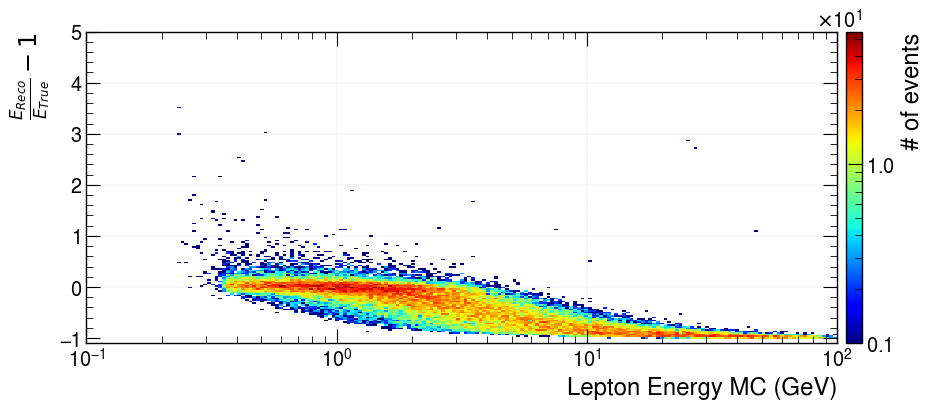

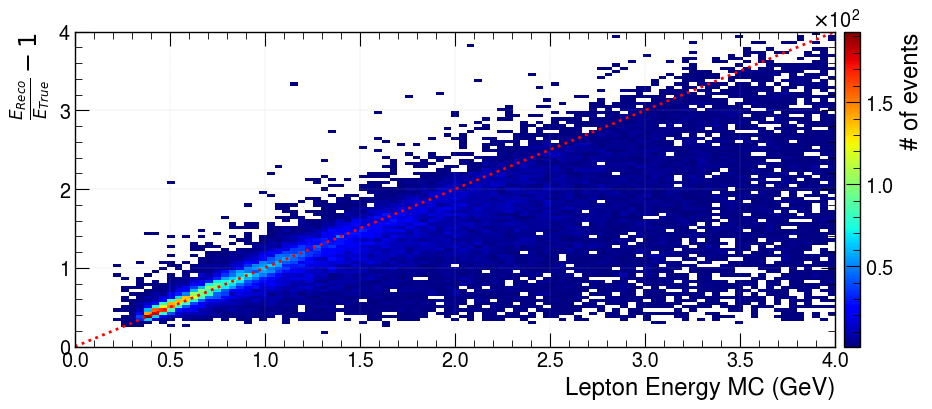

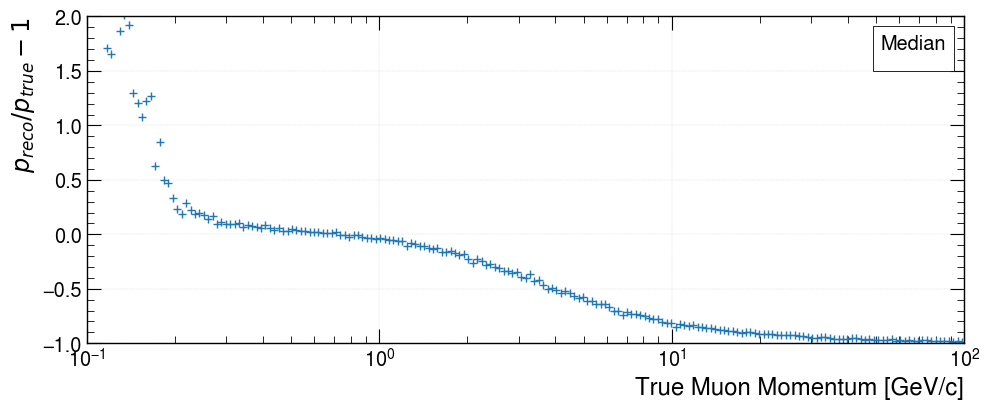

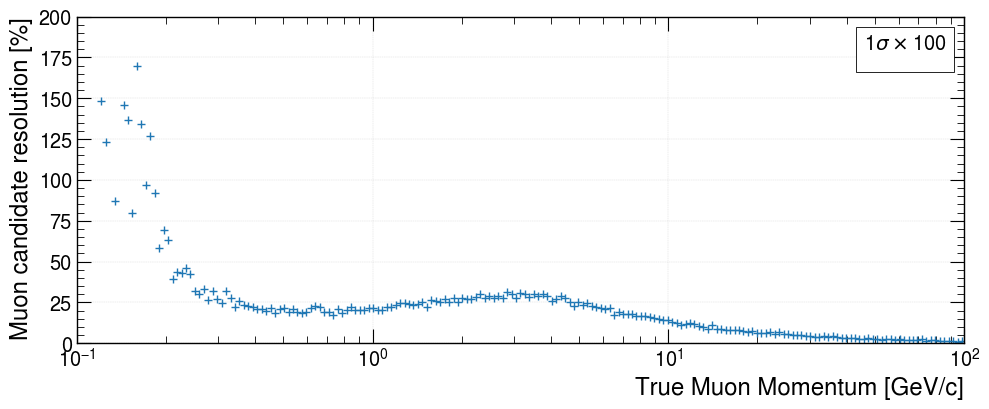

In [113]:
def event_check(df, onlycontained, Er, E='E', Elow=0, Ehigh=1e12, minlen=0, maxlen=1900, ignorecheck=False):
    return df.filter(
            (pl.col('contained')==onlycontained) | (ignorecheck)
        ).filter(
            pl.col(Er)>0
        ).filter(
            pl.col('trklen_pandoraTrack')>minlen
        ).filter(
            pl.col('trklen_pandoraTrack')<maxlen
        # ).filter(
        #     pl.col('isinverted')==False
        ).filter(
            pl.col('trklen_pandoraTrack')*0.0024 < pl.col('E')*1.1
        ).filter(
            pl.col(E) > Elow
        ).filter(
            pl.col(E) < Ehigh
        )

iscontained=False
Er = 'Ellhd'

df = event_check(dfana, iscontained,Er, minlen=100)
print(len(df))
display_2d(df['E'], df[Er])#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')

display_2d(df['E'], df[Er], makefrac=False, binsy=np.linspace(0,4,100), binsx=np.linspace(0,4,100), yscale='linear', xscale='linear', zscale=None)
plt.plot([0,100],[0,100], ':', color='r')

plt.figure()
df = event_check(dfana, iscontained,Er)
plot_res_scatter(df['E'], df[Er], infotype='median')#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')
plt.ylim(-1,2)

plt.figure()
df = event_check(dfana, iscontained,Er)
plot_res_scatter(df['E'], df[Er])#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')
plt.ylim(0,200)

/tmp/ipykernel_1269464/3947080547.py:14: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(gaus, hcenters, heigths, p0=[0,1,3500],sigma=1./np.sqrt(heigths))


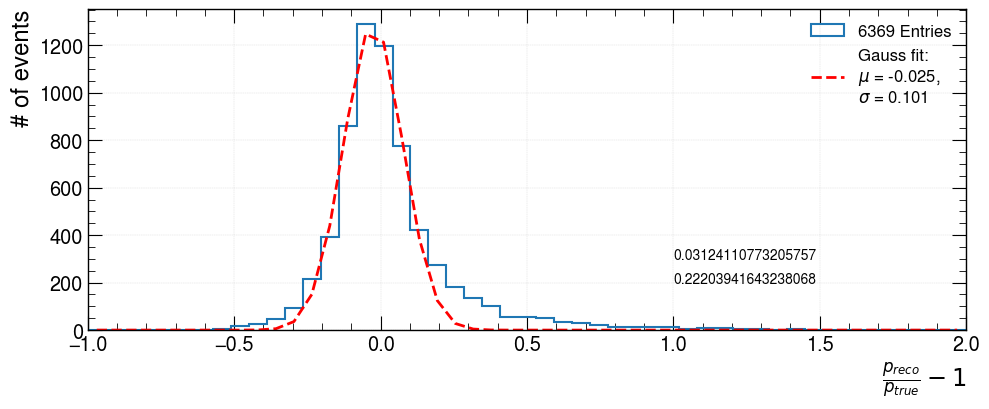

In [114]:
from scipy.optimize import curve_fit
def gaus(x, u, s, a):
    return (a/np.sqrt(2*np.pi*s*s))*np.exp(-((x-u)/s)**2/2)

plt.figure()
Er='pllhd'
iscontained=False
df = event_check(dfana,iscontained,Er,'p',0.5,1.0, minlen=100)
heigths, hedges  = plot_res(xreco=df[Er], xtrue=df['p'], binsx=np.linspace(-1,2,50), label=f'{len(df["p"]):.0f} Entries')
hcenters = (hedges[1:] + hedges[:-1])*0.5

# heigths = heigths[hcenters<0.25]
# hcenters = hcenters[hcenters<0.25]
popt, pcov = curve_fit(gaus, hcenters, heigths, p0=[0,1,3500],sigma=1./np.sqrt(heigths))
perr = np.sqrt(np.diag(pcov))
plt.plot(hcenters, gaus(hcenters, *popt), 'r--', label="Gauss fit:\n" r"$\mu$ = %5.3f," "\n" r"$\sigma$ = %5.3f" % tuple(popt)[:-1], lw=2)
plt.text(x=1,y=300,s=f'{np.mean((df["p"]/df[Er]-1).to_numpy())}')
plt.text(x=1,y=200,s=f'{np.std((df["p"]/df[Er]-1).to_numpy())}')
plt.legend()
# df = event_check(dfana, True,Er,0.4,100)
# plot_res(df['E'], df[Er], binsx=np.linspace(-1,4,200),weights=df['nuWeight_truth'])


50394


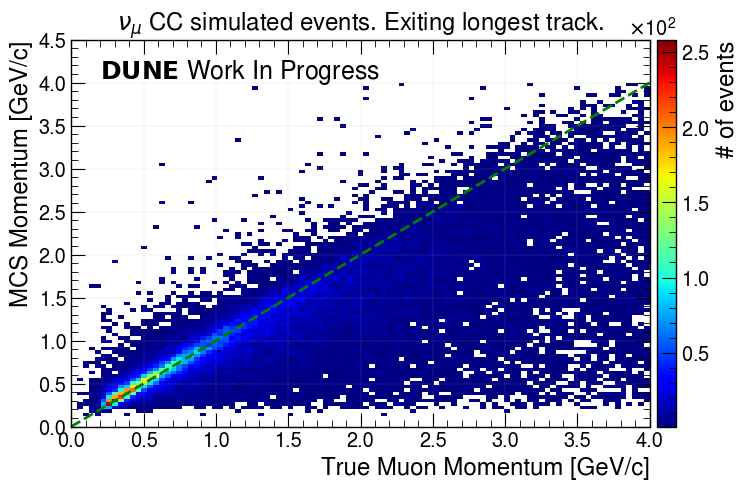

In [151]:

iscontained=False
Er = 'pllhd'
df = event_check(dfana, iscontained,Er, minlen=50, E='p', Elow=0.)
print(len(df))
iscontained=True
Erc = 'prange'
dfc = event_check(dfana, iscontained,Er, minlen=0, E='p', Elow=0.)
display_2d(df['p'],
           df[Er], 
           makefrac=False, 
           binsy=np.linspace(0,4,100), 
           binsx=np.linspace(0,4,100), 
           yscale='linear', 
           xscale='linear', 
           zscale=None,
           xlabel='True Muon Momentum [GeV/c]',
           ylabel='MCS Momentum [GeV/c]',
           figsize=(7.8,5))
plt.plot([0,100],[0,100], '--', color='green')
dunestyle.WIP()
plt.title(r'$\nu_\mu$ CC simulated events. Exiting longest track.',fontsize='xx-large')
# plt.xlim(0.,4)
plt.ylim(0.,4.5)
gname="numu_lep_mcs_reco_vs_true"
plt.savefig(f'./pdf/{gname}.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'./png/{gname}.png', dpi=300, bbox_inches='tight')


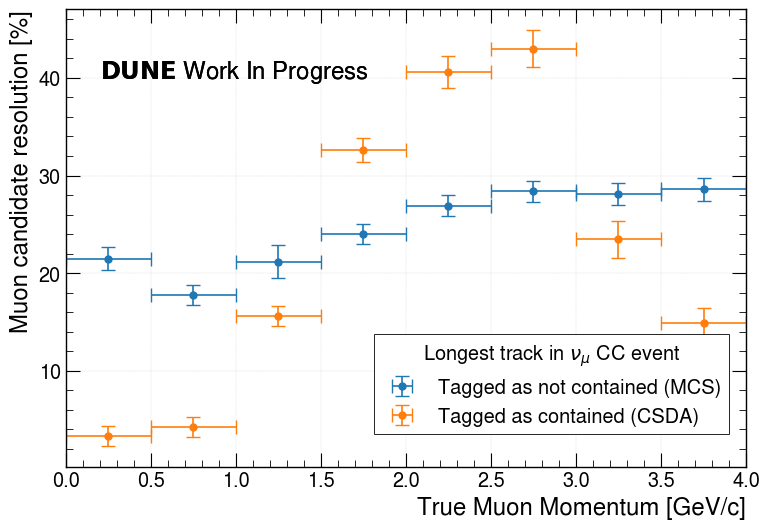

In [166]:
plt.figure(figsize=(7.8,5.4))
binsx = np.array([0.,0.5,1,1.5,2,2.5,3,3.5,4])
# binsx = np.logspace(-1,np.log10(4),20)
plot_res_scatter(df['p'],
                df[Er],
                binsx=binsx,
                title=None,
                xscale='linear',
                capsize=5,
                fmt='.',
                linewidth=1.2,
                label='Tagged as not contained (MCS)',
                loc='lower right',
                dunepos=(0.05,0.85),
                leg_ancor=(0.,0.,0.99,0.4)
                )
plot_res_scatter(dfc['p'],
                dfc[Erc],
                binsx=binsx,
                xscale='linear',
                capsize=5,
                fmt='.',
                linewidth=1.2,
                title=r'Longest track in $\nu_\mu$ CC event',
                label='Tagged as contained (CSDA)',
                loc='lower right',
                dunepos=(0.05,0.85),
                leg_ancor=(0.,0.05,0.99,0.4)
                )
plt.xlim(0,4)
gname="numu_lep_en_res"
plt.savefig(f'./pdf/{gname}.pdf', dpi=300)
plt.savefig(f'./png/{gname}.png', dpi=300)

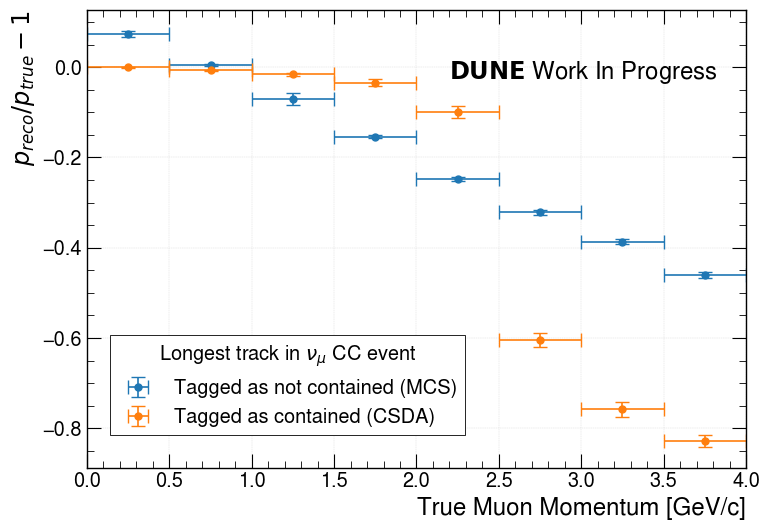

In [165]:
plt.figure(figsize=(7.8,5.4))
plot_res_scatter(df['p'],
                df[Er],
                binsx=binsx,
                infotype='median',
                title=None,
                xscale='linear',
                capsize=5,
                fmt='.',
                linewidth=1.2,
                label='Tagged as not contained (MCS)',
                loc='lower right',
                # dunepos=(0.63,0.85),
                leg_ancor=(0.,0.65,0.99,0.4)
                )
plot_res_scatter(dfc['p'],
                dfc[Erc],
                binsx=binsx,
                infotype='median',
                xscale='linear',
                capsize=5,
                fmt='.',
                linewidth=1.2,
                title=r'Longest track in $\nu_\mu$ CC event',
                label='Tagged as contained (CSDA)',
                loc='lower left',
                dunepos=(0.55,0.85),
                leg_ancor=(0.02,0.05,0.99,0.4)
                )
gname="numu_lep_en_bias"
plt.savefig(f'./pdf/{gname}.pdf', dpi=300)
plt.savefig(f'./png/{gname}.png', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 200.0)

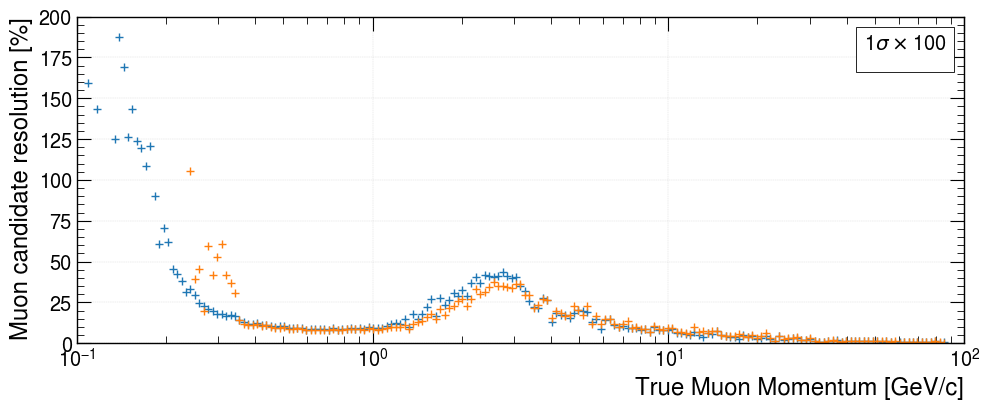

In [118]:
plt.figure()
df = event_check(dfana, iscontained,Er)
plot_res_scatter(df['E'], df[Er])#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')
df = event_check(dfana, iscontained,Er,minlen=100)
plot_res_scatter(df['E'], df[Er])#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')
plt.ylim(0,200)

<Axes: xlabel='$\\frac{p_{reco}}{p_{true}}-1$', ylabel='# of events'>

/home/henrique/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/home/henrique/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


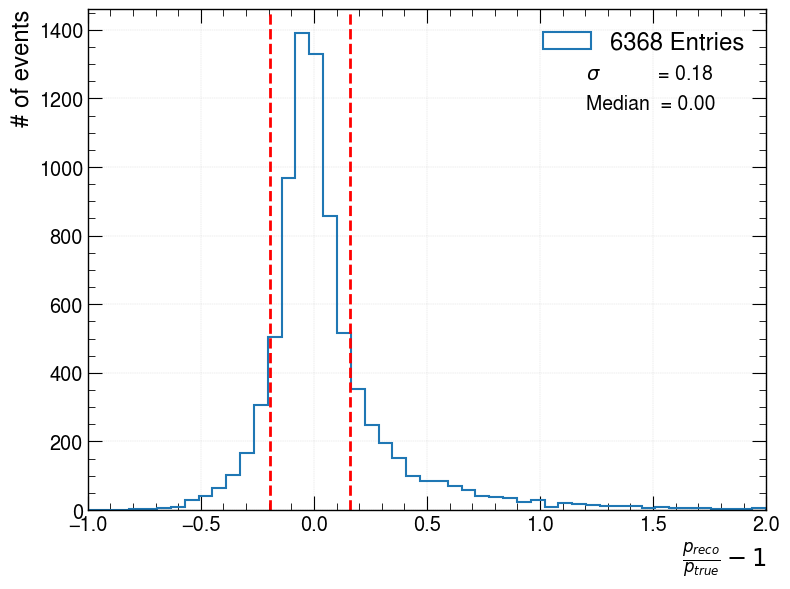

In [119]:
plt.figure(figsize=(8,6))
Er='pllhd'
iscontained=False
df = event_check(dfana,iscontained,Er,'p',0.5,1, minlen=50)
heigths, hedges  = plot_res(xreco=df[Er], xtrue=df['p'], binsx=np.linspace(-1,2,50), label=f'{np.sum(heigths):.0f} Entries')
val = df[Er]/df['p']-1
std = manual_std(val)
plt.text(0.735,0.86, '$\sigma$\t   = {0:0.2f}'.format(std), fontdict={"size":14}, transform=plt.gca().transAxes)

std0 = manual_quant(val,0.16)
plt.axvline(std0,c='r',ls='--')

std0 = manual_quant(val,0.84)
plt.axvline(std0,c='r',ls='--')

median = np.median(val)
plt.text(0.735,0.8, 'Median\t = {0:0.2f}'.format(median), fontdict={"size":14}, transform=plt.gca().transAxes)
plt.gca()



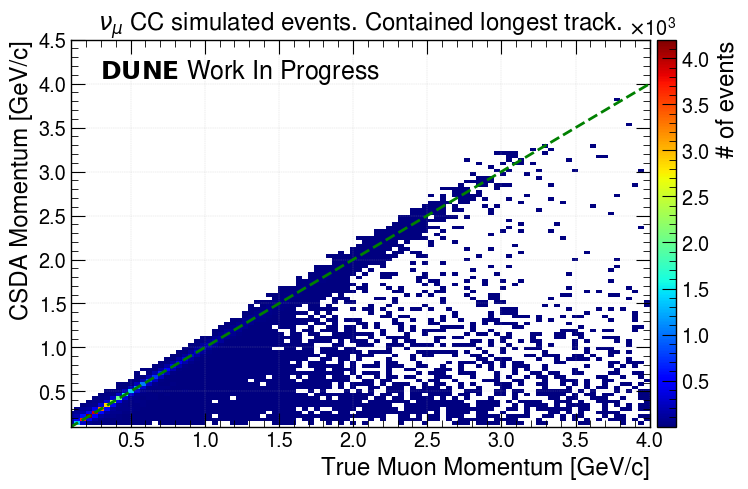

In [133]:
display_2d(dfc['p'],
           dfc[Erc], 
           makefrac=False, 
           binsy=np.linspace(0,4,100), 
           binsx=np.linspace(0,4,100), 
           yscale='linear', 
           xscale='linear', 
           zscale=None,
           xlabel='True Muon Momentum [GeV/c]',
           ylabel='CSDA Momentum [GeV/c]',
        #    figsize=(10,5))
           figsize=(7.8,5))
plt.plot([0,100],[0,100], '--', color='green')
dunestyle.WIP()
plt.title(r'$\nu_\mu$ CC simulated events. Contained longest track.',fontsize='xx-large')
# plt.xlim(0.,4)
plt.ylim(0.1,4.5)
plt.xlim(0.1,4.)

gname="numu_lep_range_reco_vs_true"
plt.savefig(f'./pdf/{gname}.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'./png/{gname}.png', dpi=300, bbox_inches='tight')

In [121]:
dfnu = event_check(dfana, False, Er="Ev_reco_nc", E='E', ignorecheck=True)
dfnu = dfnu.filter(
    ~(~(pl.col('contained')) & (pl.col('trklen')<=50))
).filter(
    pl.col('RecoMethodNumu')!=3
)


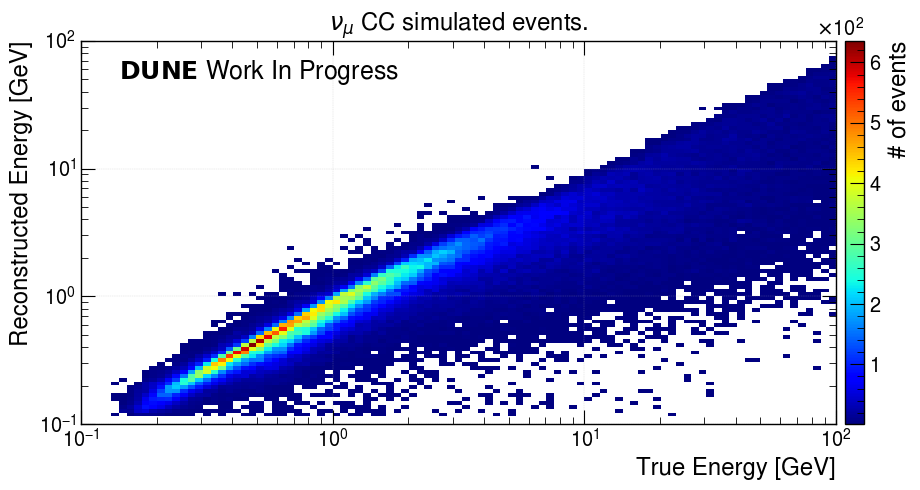

In [122]:


display_2d(
    dfnu['enu_truth'],
    dfnu['Ev_reco_numu'],
    makefrac=False, 
    binsy=np.logspace(-1,2,100), 
    binsx=np.logspace(-1,2,100), 
    yscale='log', 
    xscale='log', 
    zscale=None,
    xlabel='True Energy [GeV]',
    ylabel='Reconstructed Energy [GeV]',
    figsize=(10,5))

plt.title(r'$\nu_\mu$ CC simulated events.',fontsize='xx-large')
dunestyle.WIP()
gname="numu_reco_vs_true"
plt.savefig(f'./pdf/{gname}.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'./png/{gname}.png', dpi=300, bbox_inches='tight')

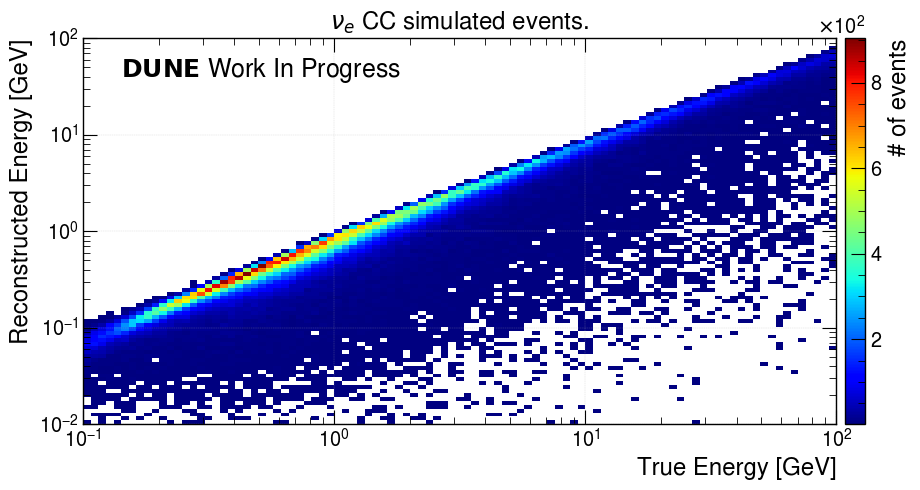

In [123]:
dfe = anatree.nu.collect()
dfe = select_numu_cc(dfe,checkContained=False,pdg=12)
dfe = dfe.filter(
    pl.col('RecoMethodNue')!=3
)
display_2d(
    dfe['enu_truth'],
    dfe['Ev_reco_nue'],
    makefrac=False, 
    binsy=np.logspace(-2,2,100), 
    binsx=np.logspace(-1,2,100), 
    yscale='log', 
    xscale='log', 
    zscale=None,
    xlabel='True Energy [GeV]',
    ylabel='Reconstructed Energy [GeV]',
    figsize=(10,5))

plt.title(r'$\nu_e$ CC simulated events.',fontsize='xx-large')
dunestyle.WIP()
gname="nue_reco_vs_true"
plt.savefig(f'./pdf/{gname}.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'./png/{gname}.png', dpi=300, bbox_inches='tight')

In [124]:
binsx = np.logspace(-1,0,10, endpoint=False)
binsx = np.append(binsx,np.logspace(0,1,6, endpoint=False))
binsx = np.append(binsx,np.logspace(1,2,4, endpoint=True))

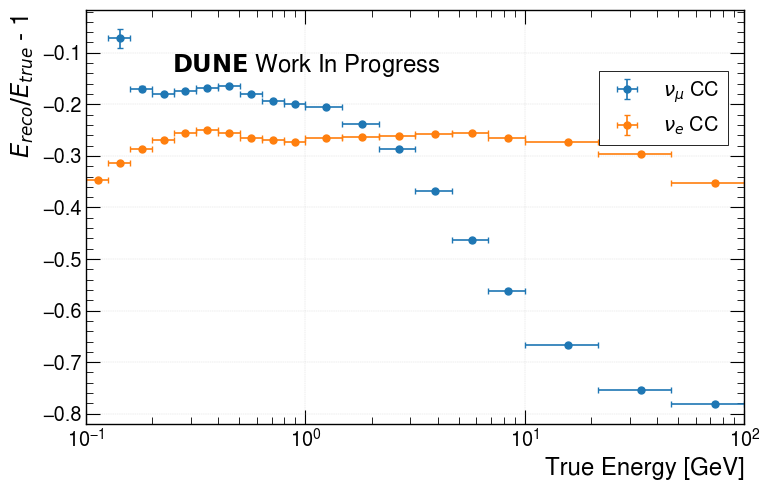

In [125]:
plt.figure(figsize=(7.8,5))
plot_res_scatter(dfnu['enu_truth'],
                 dfnu['Ev_reco_numu'],
                #  binsx=np.logspace(-1,2,50),
                 binsx=binsx,
                 infotype='median',
                 title=None,
                 xscale='log',
                #  ms=10,
                 capsize=2,
                 fmt='.',
                 linewidth=1.2,
                 label=r'$\nu_\mu$ CC',
                 ylabel=r'$E_{reco}/E_{true}$ - 1 ',
                 xlabel='True Energy [GeV]',
                 loc='lower right',
                 dunepos=None,
                 leg_ancor=(0.,0.65,0.99,0.4),
                )
plot_res_scatter(dfe['enu_truth'],
                 dfe['Ev_reco_nue'],
                #  binsx=np.logspace(-1,2,50),
                 binsx=binsx,
                 infotype='median',
                 title=None,
                 xscale='log',
                #  ms=10,
                 capsize=2,
                 fmt='.',
                 linewidth=1.2,
                 label=r'$\nu_e$ CC ',
                 ylabel=r'$E_{reco}/E_{true}$ - 1 ',
                 xlabel='True Energy [GeV]',
                 loc='lower right',
                 dunepos=(0.13,0.85),
                 leg_ancor=(0.,0.65,0.99,0.4),
                )
gname="numu_nue_en_bias"
plt.savefig(f'./pdf/{gname}.pdf', dpi=300)
plt.savefig(f'./png/{gname}.png', dpi=300)

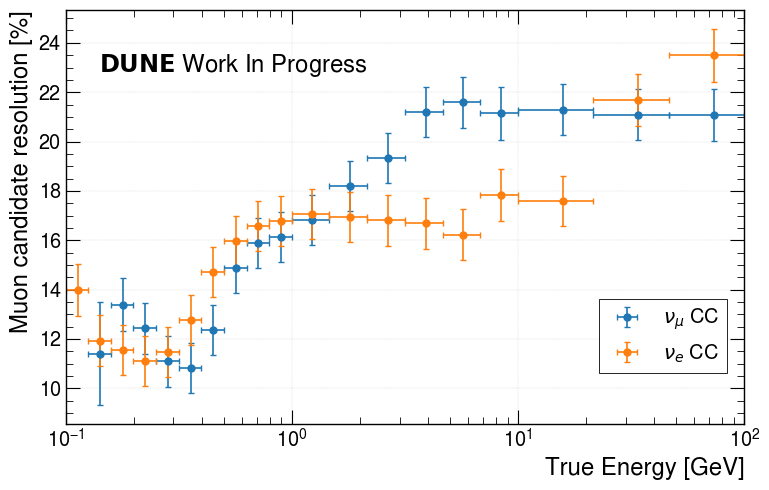

In [126]:
plt.figure(figsize=(7.8,5))
plot_res_scatter(dfnu['enu_truth'],
                 dfnu['Ev_reco_numu'],
                #  binsx=np.logspace(-1,2,50),
                 binsx=binsx,
                 title=None,
                 xscale='log',
                #  ms=10,
                 capsize=2,
                 fmt='.',
                 linewidth=1.2,
                 label=r'$\nu_\mu$ CC',
                 ylabel=r'$E_{reco}/E_{true}$ - 1 ',
                 xlabel='True Energy [GeV]',
                 loc='lower right',
                 dunepos=None,
                 leg_ancor=(0.,0.65,0.99,0.4),
                #  fo='numu_res.txt'
                )
plot_res_scatter(dfe['enu_truth'],
                 dfe['Ev_reco_nue'],
                #  binsx=np.logspace(-1,2,50),
                 binsx=binsx,
                 title=None,
                 xscale='log',
                #  ms=10,
                 capsize=2,
                 fmt='.',
                 linewidth=1.2,
                 label=r'$\nu_e$ CC ',
                 xlabel='True Energy [GeV]',
                 loc='lower right',
                 dunepos=(0.05,0.85),
                 leg_ancor=(0.,0.1,0.99,0.4),
                #  fo='nue_res.txt'
                )
gname="numu_nue_en_res"
plt.savefig(f'./pdf/{gname}.pdf', dpi=300)
plt.savefig(f'./png/{gname}.png', dpi=300)

In [127]:
dfnut = event_check(dfana, False, Er="Ev_reco_nc", E='E', ignorecheck=True)
dfnut = dfnut.filter(
    ~(~(pl.col('contained')) & (pl.col('trklen')<=50))
).filter(
    pl.col('RecoMethodNumu')==1
)
dfnut0 = dfnut.filter(
    pl.col('mode_truth')==0
)

dfnut1 = dfnut.filter(
    pl.col('mode_truth')==1
)

dfnut2 = dfnut.filter(
    pl.col('mode_truth')==2
)
dfnut3 = dfnut.filter(
    pl.col('mode_truth')==3
)

dfnutrange = dfnut.filter(
    pl.col('TrackMomMethodNumu')==1
)
dfnutmcs = dfnut.filter(
    pl.col('TrackMomMethodNumu')==0
)

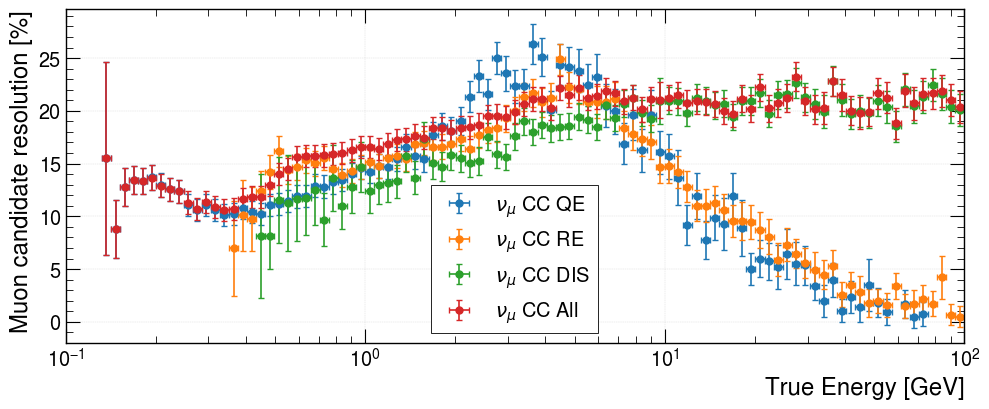

In [128]:

def just_plot(df, label):
    plot_res_scatter(df['enu_truth'],
                    df['Ev_reco_numu'],
                     binsx=np.logspace(-1,2,100),
                    # binsx=binsx,
                    title=None,
                    xscale='log',
                    #  ms=10,
                    capsize=2,
                    fmt='.',
                    linewidth=1.2,
                    label=label,
                    xlabel='True Energy [GeV]',
                    loc='best',
                    dunepos=None,
                    # leg_ancor=(0.,0.05,0.49,0.4),
                    #  fo='numu_res.txt'
    )
# print(dfnut1)
just_plot(dfnut0,label=r'$\nu_\mu$ CC QE')
just_plot(dfnut1,label=r'$\nu_\mu$ CC RE')
just_plot(dfnut2,label=r'$\nu_\mu$ CC DIS')
just_plot(dfnu,label=r'$\nu_\mu$ CC All')


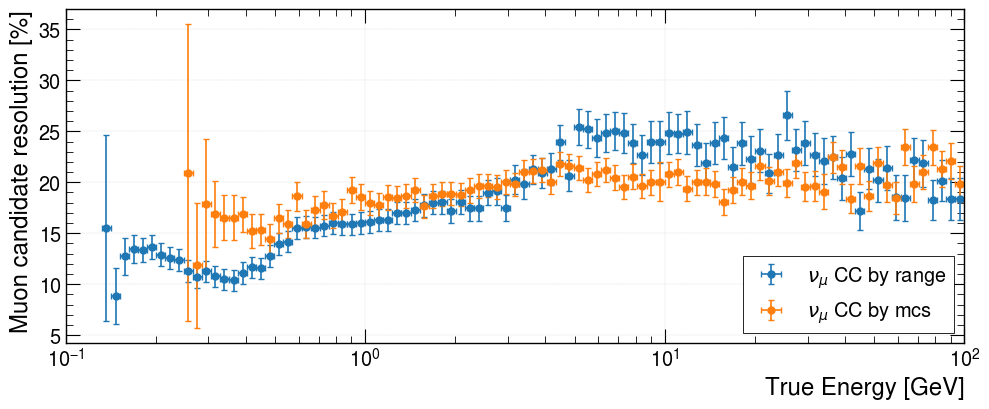

In [129]:
just_plot(dfnutrange,label=r'$\nu_\mu$ CC by range')
just_plot(dfnutmcs,label=r'$\nu_\mu$ CC by mcs')

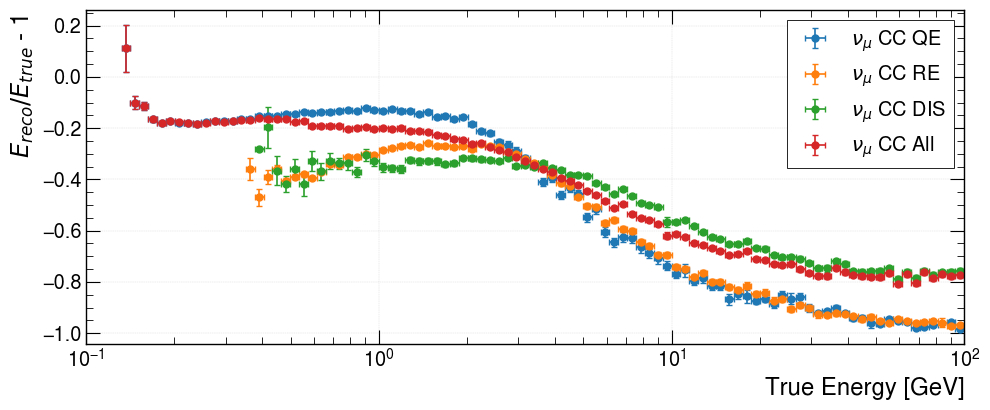

In [130]:
def just_plot(df, label):
    plot_res_scatter(df['enu_truth'],
                    df['Ev_reco_numu'],
                    binsx=np.logspace(-1,2,100),
                    # binsx=binsx,
                    infotype='median',
                    title=None,
                    xscale='log',
                    #  ms=10,
                    capsize=2,
                    fmt='.',
                    linewidth=1.2,
                    label=label,
                    ylabel=r'$E_{reco}/E_{true}$ - 1 ',
                    xlabel='True Energy [GeV]',
                    loc='upper right',
                    dunepos=None,
                    # leg_ancor=(0.,0.05,0.49,0.4),
                    #  fo='numu_res.txt'
    )
just_plot(dfnut0,label=r'$\nu_\mu$ CC QE')
just_plot(dfnut1,label=r'$\nu_\mu$ CC RE')
just_plot(dfnut2,label=r'$\nu_\mu$ CC DIS')
just_plot(dfnu,label=r'$\nu_\mu$ CC All')


Text(1, 0, 'Energy (GeV)')

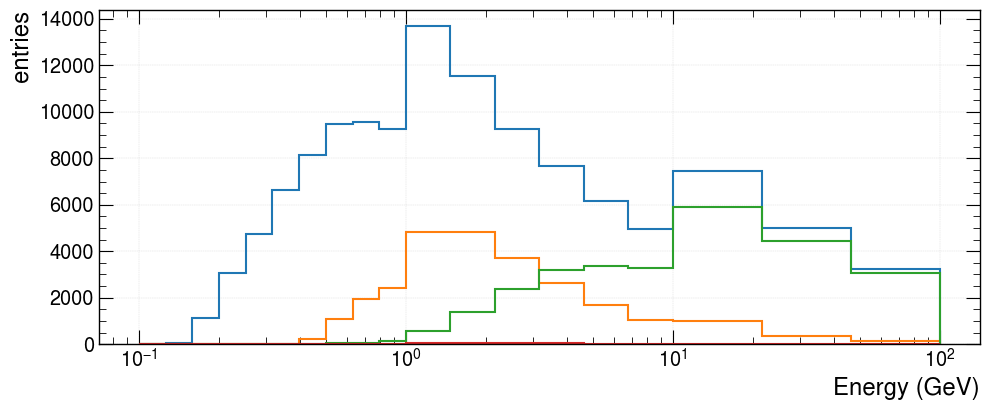

In [131]:
plt.hist(dfnu['enu_truth'],histtype='step', bins=binsx);
plt.hist(dfnut1['enu_truth'],histtype='step', bins=binsx);
plt.hist(dfnut2['enu_truth'],histtype='step', bins=binsx);
plt.hist(dfnut3['enu_truth'],histtype='step', bins=binsx);
plt.xscale('log')
plt.ylabel('entries')
plt.xlabel('Energy (GeV)')

0.03348772644996643


/tmp/ipykernel_1269464/302770648.py:11: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(gaus, hcenters, heigths, p0=[0,1,3500],sigma=1./np.sqrt(heigths))


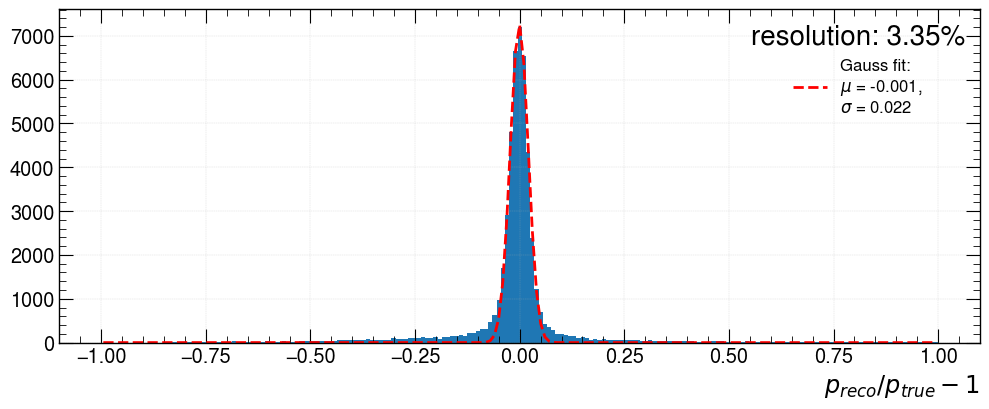

In [188]:
dtest = dfc.filter(
    (pl.col('p')>0.) & (pl.col('p')<1.)
)
heigths, hedges, _ = plt.hist(dtest["prange"]/dtest['p']-1, bins=np.linspace(-1,1,200));
print(manual_std(dtest["prange"]/dtest['p']-1))
plt.xlabel(r'$p_{reco}/p_{true} - 1$')

hcenters = (hedges[1:] + hedges[:-1])*0.5
# heigths = heigths[hcenters<0.25]
# hcenters = hcenters[hcenters<0.25]
popt, pcov = curve_fit(gaus, hcenters, heigths, p0=[0,1,3500],sigma=1./np.sqrt(heigths))
perr = np.sqrt(np.diag(pcov))
plt.plot(hcenters, gaus(hcenters, *popt), 'r--', label="Gauss fit:\n" r"$\mu$ = %5.3f," "\n" r"$\sigma$ = %5.3f" % tuple(popt)[:-1], lw=2)
plt.legend()

plt.legend(title=f'resolution: {manual_std(dtest["prange"]/dtest["p"]-1)*100:.2f}%', title_fontsize=20,)